<a href="https://colab.research.google.com/github/tachodril/Pytorch-Notebooks/blob/main/CNN%20with%20CIFAR10%20on%20GPU/CNN_with_CIFAR10_on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print('lets-begin!!')

lets-begin!!


In [2]:
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import tarfile

In [3]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
  tar.extractall(path='./data')

In [5]:
data_dir = './data/cifar10'
print(os.listdir(data_dir))
classes = os.listdir(data_dir+"/train")
print(classes)

['train', 'test']
['ship', 'bird', 'deer', 'frog', 'truck', 'dog', 'automobile', 'cat', 'horse', 'airplane']


In [6]:
frog_images=os.listdir(data_dir+'/train/frog')
print(len(frog_images))
print(frog_images[:5])

5000
['1583.png', '0252.png', '4348.png', '2789.png', '0992.png']


In [7]:
print(len(os.listdir(data_dir+'/test/frog')))

1000


In [8]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [9]:
dataset = ImageFolder(data_dir+'/train', transform = ToTensor())

torch.Size([3, 32, 32]) 0


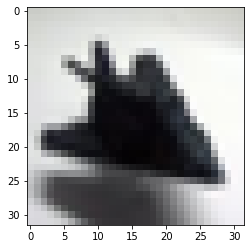

In [10]:
img, label = dataset[0]
print(img.shape, label)
plt.imshow(img.permute(1,2,0))

In [11]:
len(dataset)

50000

In [12]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [13]:
def show_example(img, label):
  print('Label:'+ dataset.classes[label]+' -- '+str(label))
  plt.imshow(img.permute(1,2,0))

Label:airplane -- 0


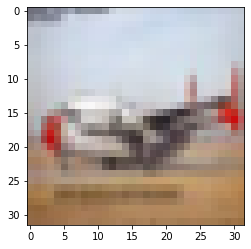

In [14]:
im, lbl = dataset[1099]
show_example(im, lbl)

Label:automobile -- 1


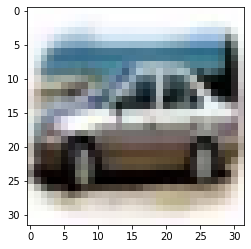

In [15]:
# other way
show_example(*dataset[9524])

In [16]:
random_seed = 25
torch.manual_seed(random_seed)

In [17]:
val_size = 5000
train_size = len(dataset)-val_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [18]:
from torch.utils.data.dataloader import DataLoader

In [25]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

# we can use double batch size for validation as for validation set,
# we will not be calculating gradients and thus, would easily handle bigger batches
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

In [26]:
from torchvision.utils import make_grid

In [27]:
def show_batch(dl):
  for images, lb in dl:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]);
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

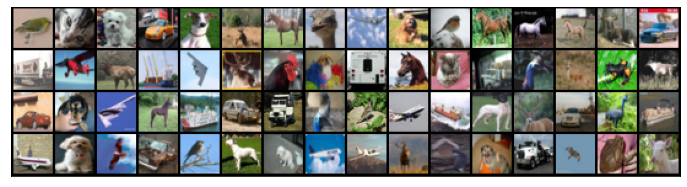

In [28]:
show_batch(train_dl)

In [29]:
# now lets start defining the model -- Tachodril

In [30]:
#lets manually try a single convolution operation
def apply_kernel(image, kernel):
  ri, ci = image.shape       # image dimensions
  rk, ck = kernel.shape      # kernel dimensions
  ro, co = ri-rk+1, ci-ck+1  # output dimensions
  output = torch.zeros([ro, co])
  for i in range(ro):
    for j in range(co):
      output[i, j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
  return output

In [31]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [32]:
import torch.nn as nn
import torch.nn.functional as F

In [33]:
# sample of a 2 layered model
temp_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(2, 2)
)

In [34]:
for img, lbl in train_dl:
  print(img.shape)
  print(temp_model(img).shape)
  break

torch.Size([64, 3, 32, 32])
torch.Size([64, 8, 16, 16])


In [35]:
class ImageClassificationBaseClass(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss':loss, 'val_acc':acc}

  def validation_epoch_end(self, out):
    batch_losses = [x['val_loss'] for x in out]
    batch_accs = [x['val_acc'] for x in out]
    return {
        'val_loss': torch.stack(batch_losses).mean().item(),
        'val_acc': torch.stack(batch_accs).mean().item()
        }

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [36]:
def accuracy(out, labels):
  _, preds = torch.max(out, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [37]:
class Cifar10CnnModel(ImageClassificationBaseClass):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
    
  def forward(self, xb):
    return self.network(xb)

In [38]:
model=Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [39]:
for images, labels in train_dl:
  print(images.shape)
  print(model(images).shape)
  break

torch.Size([64, 3, 32, 32])
torch.Size([64, 10])


In [40]:
# now lets transfer all the data and model to the GPU before training

In [41]:
torch.cuda.is_available()

True

In [42]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

In [43]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl=dl
    self.device=device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [44]:
device = torch.device('cpu')
if torch.cuda.is_available():
  device = torch.device('cuda')

In [45]:
device

device(type='cuda')

In [46]:
#transfer data to GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [47]:
# transfer the model to GPU
model = to_device(Cifar10CnnModel(), device)

In [48]:
def evaluate(model, val_loader):
  model.eval()
  out = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(out)

In [49]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
  hist=[]
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    model.train() # this notifies that model is going to training phase
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    res = evaluate(model, val_loader)
    res['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, res)
    hist.append(res)
  return hist

In [50]:
#lets check on untrained model
evaluate(model, val_dl)

{'val_acc': 0.09691455960273743, 'val_loss': 2.303149938583374}

In [51]:
num_epochs = 10
opt_fn = torch.optim.Adam
lr = 0.001

In [52]:
# finally, lets train -- Tachodril

In [53]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_fn)

Epoch [0], train_loss: 1.7931, val_loss: 1.5650, val_acc: 0.4331
Epoch [1], train_loss: 1.3171, val_loss: 1.3360, val_acc: 0.5334
Epoch [2], train_loss: 1.0521, val_loss: 1.0459, val_acc: 0.6371
Epoch [3], train_loss: 0.8795, val_loss: 0.8868, val_acc: 0.6883
Epoch [4], train_loss: 0.7599, val_loss: 0.8341, val_acc: 0.7089
Epoch [5], train_loss: 0.6534, val_loss: 0.7653, val_acc: 0.7324
Epoch [6], train_loss: 0.5690, val_loss: 0.8262, val_acc: 0.7116
Epoch [7], train_loss: 0.4953, val_loss: 0.7844, val_acc: 0.7364
Epoch [8], train_loss: 0.4156, val_loss: 0.8468, val_acc: 0.7312
Epoch [9], train_loss: 0.3531, val_loss: 0.9556, val_acc: 0.7251


In [54]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

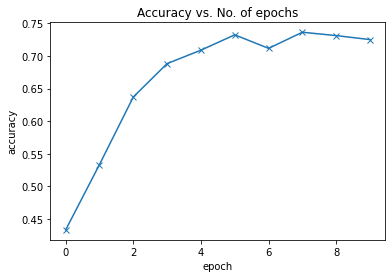

In [55]:
plot_accuracies(history)

In [56]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

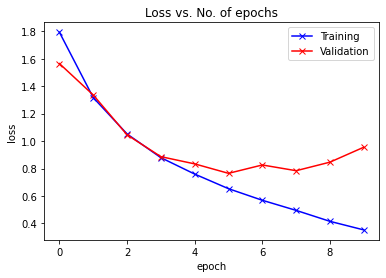

In [57]:
plot_losses(history)

In [58]:
# now lets test with testing dataset

In [59]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [60]:
def predict(img, model):
  xb = to_device(img.unsqueeze(0), device)
  yb = model(xb)
  _, preds = torch.max(yb, dim=1)
  return dataset.classes[preds[0].item()]

Label: airplane , Predicted: airplane


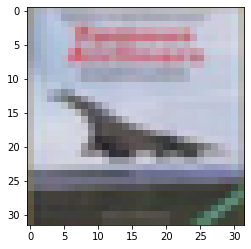

In [61]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict(img, model))

Label: automobile , Predicted: automobile


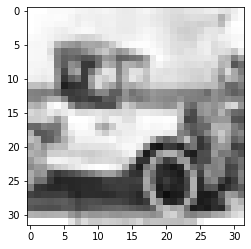

In [62]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict(img, model))

In [64]:
# test_loader = DeviceDataLoader(DataLoader(test_dataset, 64), device)
# res = evaluate(model, test_loader)
# res

In [65]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [66]:
#done for now -- Tachodril